# 10. 階層ベイズモデル -GLMMのベイズモデル化-

* 9章では、無情報事前分布を使ったベイズ統計モデル
* 10章では、階層事前分布を使って一般化線形混合モデル(GLMM)を階層ベイズモデルとして扱う
    * 現実的な統計モデルを構築するためには、無情報事前分布だけではなく、階層事前分布も使わなければならない
* 階層ベイズモデルとMCMCサンプリングによるパラメータ推定は、複雑な統計モデルの時に威力を発揮する。

## 10.1.例題：個体差と生存種子数（個体差あり）

* 種子の生存確率を調べる問題
* 100個体からそれぞれ、8つの種子を取り出し、生存数を数える。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data_df = pd.read_csv("./input/data7a.csv")

rng = np.random.RandomState(160)

In [2]:
data_df.head()

,id,y
0,1,0
1,2,2
2,3,7
3,4,8
4,5,1


* 説明変数$x$は存在しない

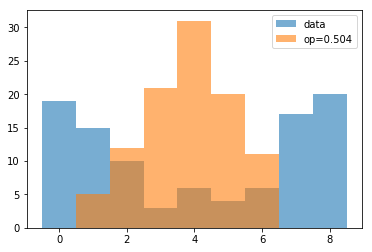

In [3]:
# 生起確率0.504で、8個取り出すのを100回繰り返し、リストに入れる。
y_list = rng.binomial(8,0.504,100)

plt.hist(data_df.y,bins=np.arange(10)-0.5,alpha=0.6,label="data")
plt.hist(y_list,bins=np.arange(10)-0.5,alpha=0.6,label="op=0.504")
plt.legend()

* 個体に由来するランダム効果によって、過分散が生じているようだ。

## 10.2. GLMMの階層ベイズモデル化

* 種子生存確率$q$が全個体で共通していると仮定する統計モデルでは、説明できない。
* 個体ごとに由来する差異を組み込んだGLMである、「GLMM」を用いる必要


#### これまで
* 個体差だけを組み込んだGLMMなら、パラメータ推定も比較的簡単だった。(7章)
* 個体差だけでなく、場所差も考慮するGLMMはパラメータ推定困難。
* この問題を解決するためには、8章、9章で学んだ、「ベイズ統計モデルとMCMCサンプリングによる事後分布の推定」が有効だろう
* 9章ではGLMのベイズモデル化を行なった(ランダム効果$r$は出てこなかった)が、10章ではGLMMのベイズモデル化を行う。

### 統計モデルの設計

* リンク関数と線形予測子は下記とする。
$$
logit(q_i) = \log \frac {q_i}{1-q_i} = \beta + r_i
$$
* $\beta$は全個体に共通するパラメーター
* $r_i$は個体差を表す。平均ゼロで標準偏差$s$の正規分布に従うと仮定。
* データが得られる確率は
$$
p({\bf Y} | \beta, \{r_i\}) = \prod_i \binom {8}{y_i} q_i^{y_i} (1-q_i)^{8-y_i}
$$
* 推定したい事後分布は
    * 事後分布　$　\propto p({\bf Y} | \beta,\{r_i\})\times$事前分布
* あとは事前分布を指定すれば統計モデルの設計は完了

### 事前分布の設計

* $\beta$は正負どのような値を取っても良い実数。
    * (滝沢補足)$\log \frac {q_i}{1-q_i}$の範囲は[$-\infty,\infty$]のため、かな。
* $\beta$の事前分布として、無情報事前分布を指定する。
    * 平均ゼロ、標準偏差100のひらべったい正規分布とする。
    $$
    p(\beta) = \frac {1}{\sqrt {2\pi \times 100^2}}\exp \left(\frac {-\beta^2}{2\times100^2} \right)
    $$
* 個体差$r_i$の事前分布は平均ゼロ、標準偏差$s$の正規分布と仮定する(7章と同様）
    * $s$は個体差を表す100個の$r_i$がどれくらいバラついてるかを表す。
    $$
    p(r_i | s) = \frac {1}{\sqrt {2\pi s^2}}\exp \left(\frac {-{r_i}^2}{2 s^2} \right)
    $$


### $s$ の扱いを決める

* 第7章の例題では、最尤推定によって、一つの値である$\hat s$を特定した。
* ベイズ統計モデルでは、確率分布である$s$の事後分布を推定する。
* 事後分布を推定するためには事前分布を指定しなければならない。
* $s$は正の値であればなんでも構わないので、無情報事前分布とし、
    * $p(s) = $(0から$10^4$までの連続一様分布)

### 階層ベイズモデルとは

* 下記の時、$p(r_i|s)$を階層事前分布と呼ぶ。($p(r_i|s)p(s)$をまとめてそう呼ぶこともある)
    1. 個体差$r_i$の事前分布$p(r_i|s)$の形を決める$s$というパラメータがあり、
    2. この$s$についても事前分布$p(s)$が設定されている時
    
* 階層とは事前分布のパラメータにさらに事前分布が設定されていること
* $p(r_i | s)$のパラメータ$s$は超パラメーター(hyper parameter)、事前分布の事前分布である$p(s)$は超事前分布と呼ばれる場合もある。
* 階層事前分布を使っているベイズ統計モデルが階層ベイズモデル。

## 10.3. 階層ベイズモデルの推定・予測

* この例題の階層ベイズモデルの事後分布は下記のようにかける
$$
p(\beta, s, {r_i} | {\bf Y}) \propto p({\bf Y} | \beta,\{r_i\}) p(\beta) p(s) \prod_i p(r_i | s)
$$
    * (滝沢補足)上の式だと階層がわかりづらいが、$p(s)$がもっとも下の階層(事前分布の事前分布)

* 階層ベイズモデルと観測データから事後分布を推定する手順と結果を示す。
    * 引き続き、Stanで行う。

### 10.3.1. 階層ベイズモデルのMCMCサンプリング

#### モデル

In [4]:
model = """
data {
    int<lower=0> N; //サンプルサイズ
    int<lower=0> y[N];//生存数
}

parameters {
    real beta;
    real r[N];　//個体差
    real <lower=0> s;　//個体差のばらつき
}

# trans-param では、data及びparametersで
# 宣言されたパラメータと定数値から、
# 新たにサンプリングする変数を作ることができる
transformed parameters {
    real q[N];
    for (i in 1:N)
        q[i] =inv_logit(beta+r[i]);
}

model {
    for (i in 1:N)
        y[i] ~ binomial(8,q[i]); //二項分布
        
    beta ~ normal(0, 100); //betaの事前分布は標準偏差100の正規分布
    
    for (i in 1:N)
        r[i] ~ normal(0,s); // rの事前分布は標準偏差s
    
    s ~ uniform(0,10000); // sの事前分布は0<s<10000の一様分布
}
"""

### 10.3.2. 階層ベイズモデルの事後分布推定と予測

* パラメータの事後分布からのMCMCサンプリングを行う。

In [5]:
y = data_df.y
N = y.shape[0]

# stanに辞書型でデータを引き渡す
stan_data = {"N": N, "y": y}

In [6]:
import pystan


# MCMCサンプリングのステップ数
iter_count= 1600

# MCMCサンプリングの反復数の指定(WinBUGSではデフォルト3)
chain_count = 3

# MCMCサンプリングの最初の何ステップの結果を使わないとするか(burnin)
warmup_count = 100

# MCMCサンプリングのステップのうち、何個飛ばしでサンプリング結果を記録するか
thin_count = 3

fit = pystan.stan(model_code=model,
                  data=stan_data,
                  iter=iter_count,
                  chains=chain_count,
                  thin=thin_count,
                  warmup=warmup_count)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_69663eb8116a7e68936a182abad0dcd9 NOW.


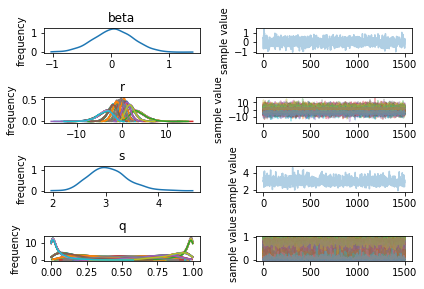

In [7]:
fit.plot()
plt.tight_layout()

In [8]:
result = fit.extract()

sample_df = pd.DataFrame()
sample_df["beta"] = result["beta"]

for i in range(result["r"].shape[1]):
    column_name = "r"+str(i+1)
    sample_df[column_name] = result["r"][:,i]
    
sample_df["s"] = result["s"]
for i in range(result["q"].shape[1]):
    column_name = "q"+str(i+1)
    sample_df[column_name] = result["q"][:,i]

In [9]:
sample_df.head()

,beta,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,q91,q92,q93,q94,q95,q96,q97,q98,q99,q100
0,0.444103,-5.600582,-1.130515,2.662691,1.304224,-1.944581,1.775517,2.129387,3.268738,-1.998186,...,0.790946,0.156459,0.404475,0.798771,0.866808,0.278233,0.012772,0.555682,0.893832,0.010885
1,0.505811,-3.240757,-1.931871,2.020406,9.850625,-3.379821,3.316582,2.336106,3.511568,-2.634638,...,0.421213,0.333484,0.997467,0.727483,0.866402,0.292383,0.060905,0.609488,0.857055,0.010365
2,-0.667088,-4.372790,-0.509573,1.131752,3.492351,-1.569672,2.067603,4.435829,3.223807,-0.796005,...,0.728808,0.508464,0.955133,0.737589,0.571870,0.256093,0.029660,0.516112,0.870214,0.005003
3,0.414844,-5.817324,-2.538411,2.409314,7.345794,-3.474456,0.557974,5.270660,2.138562,-0.803608,...,0.860432,0.112197,0.989601,0.789610,0.629857,0.200444,0.134160,0.393016,0.911712,0.036801
4,0.391362,-3.712341,-2.050513,3.457260,2.880765,-5.294788,3.077498,3.515320,3.365418,-4.609613,...,0.823165,0.258631,0.734150,0.849336,0.884330,0.159015,0.160604,0.316462,0.963789,0.004870


### 各事後分布

#### $\beta$の事後分布(1500個のサンプル)

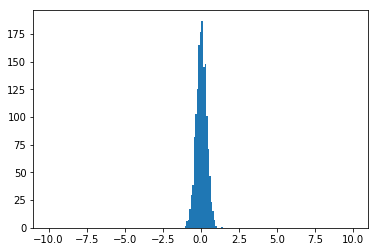

In [10]:
plt.hist(sample_df.beta,bins=np.linspace(-10,10,200))
plt.show()

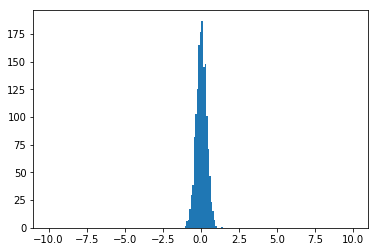

In [11]:
plt.hist(sample_df.beta,bins=np.linspace(-10,10,200))
plt.show()

#### $s$の事後分布

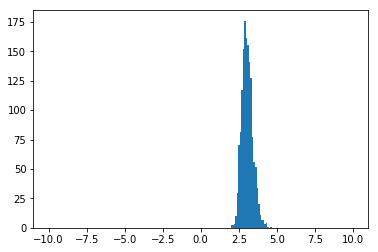

In [12]:
plt.hist(sample_df.s,bins=np.linspace(-10,10,200))
plt.show()

#### $r_1$の事後分布 ( $r$ は個体ごとに固有のため、$r_
{100}$まで存在する。)

* sの値が事後分布の中央値となっている場合の事前分布$p(r_i | s)$も記載

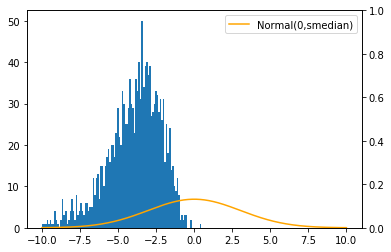

In [13]:
fig,ax1 = plt.subplots()
ax1.hist(sample_df.r1,bins=np.linspace(-10,10,200))

# sが事後分布の中央値である場合の事前分布
ax2 = ax1.twinx()

smedian = sample_df.s.median()

x = np.linspace(-10,10,2000)
y = (1.0/np.sqrt(2*np.pi*(smedian**2))) * np.exp(-(x**2)/(2*(smedian**2)))
ax2.plot(x,y,"orange",label="Normal(0,smedian)")
ax2.set(ylim=(0,1))

plt.legend()
plt.show()

### 図10.4の作成(できてない)
* おそらく図の作成過程についての僕の認識が間違えている

In [14]:
sample_df[["beta","s"]].head()

,beta,s
0,0.444103,3.084453
1,0.505811,3.068926
2,-0.667088,3.028517
3,0.414844,3.554227
4,0.391362,2.986082


In [15]:
pred_df = pd.DataFrame()
for i in range(9):
    column_name = "s" + str(i)
    pred_df[column_name] = np.zeros(1500)

for i, params in sample_df[["beta","s"]].iterrows():
    beta = params[0]
    s = params[1]
    
    survival_seeds_list = []
    for _ in range(100):
        # r_iは毎回標準偏差sの正規分布を元に決める
        r = rng.normal( 0, s, 1)
        q = 1/(1+np.exp(-(beta+r)))
    
        survival_seeds_list.append(rng.binomial(8,q,1))
    
    unique, counts = np.unique(survival_seeds_list,return_counts=True)
    
    for u,c in zip(unique,counts):
        pred_df.loc[i,"s"+str(u)] = c        

In [16]:
pred_df.head()

,s0,s1,s2,s3,s4,s5,s6,s7,s8
0,20.0,10.0,10.0,5.0,3.0,10.0,9.0,11.0,22.0
1,15.0,7.0,6.0,5.0,4.0,6.0,9.0,16.0,32.0
2,31.0,11.0,6.0,2.0,5.0,5.0,11.0,11.0,18.0
3,18.0,11.0,7.0,1.0,4.0,7.0,10.0,15.0,27.0
4,19.0,16.0,9.0,5.0,7.0,4.0,10.0,12.0,18.0


In [17]:
pred_df.describe()

,s0,s1,s2,s3,s4,s5,s6,s7,s8
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,21.419333,10.372667,7.746000,6.534000,6.504667,6.754667,7.690000,10.841333,22.137333
std,5.685746,3.130120,2.703521,2.573699,2.601504,2.637508,2.766044,3.162092,5.428147
min,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,6.000000
25%,17.000000,8.000000,6.000000,5.000000,5.000000,5.000000,6.000000,9.000000,18.000000
50%,21.000000,10.000000,8.000000,6.000000,6.000000,7.000000,8.000000,11.000000,22.000000
75%,25.000000,12.000000,9.000000,8.000000,8.000000,8.000000,10.000000,13.000000,26.000000
max,39.000000,20.000000,18.000000,17.000000,15.000000,18.000000,18.000000,23.000000,40.000000


* 中央値は50%の行を見れば良い

In [18]:
# 下から2.5%
pred_df.quantile(.025)

s0    11.0
s1     5.0
s2     3.0
s3     2.0
s4     2.0
s5     2.0
s6     3.0
s7     5.0
s8    12.0
Name: 0.025, dtype: float64

In [19]:
# 下から97.5%(上から2.5%)
pred_df.quantile(0.975)

s0    33.0
s1    17.0
s2    14.0
s3    12.0
s4    12.0
s5    12.0
s6    13.0
s7    17.0
s8    33.0
Name: 0.975, dtype: float64

* 図10.4のようなグラフは作れてないが、グラフから読み取れる情報は取得できた

## 10.4. ベイズモデルで使う様々な事前分布

* ベイズ統計モデルの設計で重要になるのは事前分布の選択
* 下記の3種類が主
    1. 主観的な事前分布
        * データ解析者の主観で決める。
        * この本では用いない。必要となることは多くない。
    2. 無情報事前分布
        * 100個の$r_i$をそれぞれ自由に決めるので、統計モデルとして望ましくない。フルモデルと同じ。
    3. 階層事前分布
        * $p(r_i | s)$を平均ゼロ、標準偏差$s$の正規分布であるとした。
        * そしてこの$s$の事前分布$p(s)$は無情報事前分布であると設定する。そのため階層はこれ以上は深くならない。
* あるパラメータの事前分布として、無情報事前分布、階層事前分布のどちらを選ぶべきか？
    * パラメータがデータ全体のどの範囲を説明しているかに依存すると考えて良い。
        * 説明する範囲が大域的なもの：無情報事前分布
        * 説明する範囲が局所的なもの：階層事前分布
* 階層ベイズモデルは、多数の局所的なパラメータをまとめて取り扱うために、階層事前分布を設定し、この階層事前分布を少数の大域的パラメータ（無情報事前分布)で支配する。

## 10.5. 個体差 + 場所差の階層ベイズモデル

* 個体差だけでなく、場所差も組み込んだ階層ベイズモデルについて考える。

### 例題

* 100個の個体がある
* 10個体ずつに異なる植木鉢(A~J)で育てられている。
* 植木鉢A~Eは無処理、F~Jは施肥処理

In [20]:
kb_df = pd.read_csv("./input/d1.csv",dtype={"pot":"category","f":"category"})

In [21]:
kb_df.head()

,id,pot,f,y
0,1,A,C,6
1,2,A,C,3
2,3,A,C,19
3,4,A,C,5
4,5,A,C,0


In [22]:
kb_df[:50].describe()

,id,y
count,50.00000,50.000000
mean,25.50000,6.640000
std,14.57738,7.227386
min,1.00000,0.000000
25%,13.25000,2.000000
50%,25.50000,4.000000
75%,37.75000,8.000000
max,50.00000,29.000000


### 図10.7

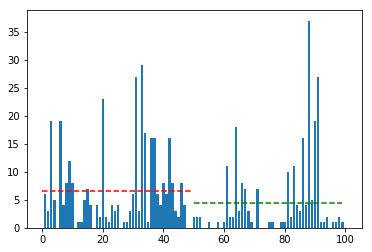

In [23]:
plt.bar(kb_df.id,kb_df.y)

mean_c = kb_df[kb_df.f.cat.codes==0].y.mean()
mean_t = kb_df[kb_df.f.cat.codes==1].y.mean()

plt.plot(np.arange(50),[mean_c]*50,"r--")
plt.plot(np.arange(50,100),[mean_t]*50,"g--")

In [24]:
print(mean_c)

6.64


* 無処理の平均は6.64。ポアソン分布に従うとすると、標準偏差は

In [25]:
np.sqrt(mean_c)

2.5768197453450252

* 図を見ると、それよりも大きく見える。過分散が発生している。

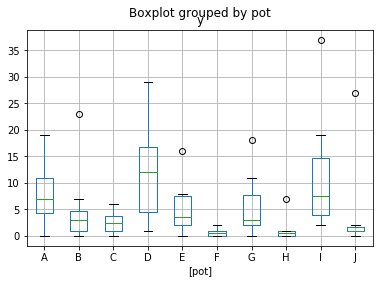

In [26]:
kb_df[["y","pot"]].boxplot(by="pot")

* 過分散の原因は、植木鉢にもありそうだ。
* 個体も植木鉢も、どちらも反復ではなく擬似反復なので、個体差と植木鉢差を同時に扱う統計モデルを作らなければならない。
    * 擬似反復とは、反復っぽく見えるが個体差・場所差を打ち消す反復になっていないもの。個体差・場所差が推定可能であり、かつその差の影響を考慮しなければ、推定結果に偏りが生じる。(7.5)
* これはGLMM化したポアソン回帰で扱える問題なので下記で表現できる。
$$
p(y_i|\lambda_i) = \frac {\lambda_i^{y_i} \exp(-\lambda_i)} {y_i !}
$$
* 平均種子数$\lambda_i$は、
$$
\log \lambda_i = \beta_1 + \beta_2 f_i + r_i + r_{j(i)}
$$
    * $r_{j(i)}$は、個体$i$がいる植木鉢$j$の効果
    * $r_i$は100個、$r_{j(i)}$は10個
    * それぞれのばらつきを$s$と$s_p$とする
* 上記のパラメータの事前分布は
    * 大域的な平均パラメータである$\beta_1,\beta_2$は無情報事前分布(平均ゼロ)
    * 大域的なばらつきパラメータである$s,s_p$は無情報事前分布(0から$10^4$の範囲を取る一様分布)
    * 局所的パラメーターである$r_i,r_{j(i)}$は階層事前分布(平均ゼロで標準偏差はそれぞれ$s,s_p$)

In [27]:
model10_5 = """
data {
  int<lower=0> N_sample;       // number of observations
  int<lower=0> N_pot;          // number of pots
  int<lower=0> N_sigma;        // number of sigmas
  int<lower=0> Y[N_sample];    // number of seeds
  int<lower=0> F[N_sample];    // fertilizer
  int<lower=0> Pot[N_sample];  // pot
}
parameters {
  real beta1;
  real beta2;
  real r[N_sample];
  real rp[N_pot];
  real<lower=0> sigma[N_sigma];
}
transformed parameters {
  real<lower=0> lambda[N_sample];

  for (i in 1:N_sample) {
    lambda[i] <- exp(beta1 + beta2 * F[i] + r[i] + rp[Pot[i]]);
  }
}
model {
  for (i in 1:N_sample) {
    Y[i] ~ poisson(lambda[i]);
  }
  beta1 ~ normal(0, 100);
  beta2 ~ normal(0, 100);
  r ~ normal(0, sigma[1]);
  rp ~ normal(0, sigma[2]);
  for (k in 1:N_sigma) {
    sigma[k] ~ uniform(0, 1.0e+4);
  }
}
"""

In [28]:
kb_df.f.cat.codes

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
     ..
70    1
71    1
72    1
73    1
74    1
75    1
76    1
77    1
78    1
79    1
80    1
81    1
82    1
83    1
84    1
85    1
86    1
87    1
88    1
89    1
90    1
91    1
92    1
93    1
94    1
95    1
96    1
97    1
98    1
99    1
Length: 100, dtype: int8

In [29]:
y = kb_df.y
N_sample = kb_df.shape[0]
N_pot = kb_df.pot.drop_duplicates().shape[0]
N_sigma = 2
Y = kb_df.y
# Stanではカテゴリは0で表してはいけないようなので、
# 1足している。
F = kb_df.f.cat.codes + 1
Pot = kb_df.pot.cat.codes + 1

# stanに辞書型でデータを引き渡す
stan_data10_5 = {"y": y,"N_sample":N_sample,"N_pot":N_pot,
             "N_sigma":N_sigma,"Y":Y,"F":F,"Pot":Pot}

In [30]:
# MCMCサンプリングのステップ数
iter_count= 1600

# MCMCサンプリングの反復数の指定(WinBUGSではデフォルト3)
chain_count = 3

# MCMCサンプリングの最初の何ステップの結果を使わないとするか(burnin)
warmup_count = 100

# MCMCサンプリングのステップのうち、何個飛ばしでサンプリング結果を記録するか
thin_count = 3

fit10_5 = pystan.stan(model_code=model10_5,
                  data=stan_data10_5,
                  iter=iter_count,
                  chains=chain_count,
                  thin=thin_count,
                  warmup=warmup_count)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_461608a512c06a4653e1650bcd1fbc55 NOW.


In [31]:
fit10_5

Inference for Stan model: anon_model_461608a512c06a4653e1650bcd1fbc55.
3 chains, each with iter=1600; warmup=100; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1500.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1         2.3    0.06   1.34  -0.02    1.5   2.22   2.98    5.3    586    1.0
beta2        -0.9    0.04   0.87  -2.74  -1.36  -0.85  -0.39   0.63    534    1.0
r[0]        -0.02    0.01   0.48  -1.02  -0.34 6.9e-3    0.3   0.92   1472    1.0
r[1]        -0.59    0.01   0.55   -1.7  -0.95  -0.56   -0.2   0.44   1359    1.0
r[2]         1.09    0.01    0.4   0.32   0.83   1.09   1.34   1.87   1441    1.0
r[3]        -0.19    0.01    0.5   -1.2  -0.54  -0.18   0.15   0.78   1500    1.0
r[4]        -1.59    0.02   0.72  -3.07  -2.06  -1.55  -1.08  -0.37   1500    1.0
r[5]         1.09    0.01    0.4   0.31   0.81   1.08   1.37   1.87   1222    1.0
r[6]         -0.4    0.01   0.51  -1.41  -0.76  -0.38  -0.04   0.57   1500 

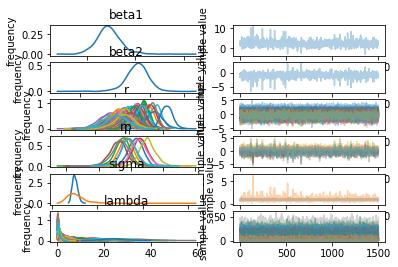

In [32]:
fit10_5.plot()
plt.show()

* $\beta_2$の事後分布の95%区間にはゼロが含まれ、施肥処理は何の効果もなさそうだ。
* 統計モデリングで手抜きをすると、「あるはずのない処理の効果」が「推定」されてしまう。例えば、個体差・植木鉢差を無視したGLMや、個体差だけ組み込んだGLMMの推定では、どちらも「肥料によって平均種子数が低下する」という結果がAIC最良となってしまう。

## 10.6 この章のまとめと参考文献

* この本のゴール(図1.2)となる、階層ベイズモデルを扱った。
* GLMMをベイズモデル化すると、階層ベイズモデルになる。
* 階層ベイズモデルは、事前分布となる確率分布のパラメータにも事前分布が指定されている統計モデル。
* 無情報事前分布と階層事前分布を使い、主観的な事前分布は用いない。
* 複雑な構造のあるデータの統計モデリングでは、階層ベイズモデルとMCMCサンプリングによるパラメータ推定の組み合わせで対処するのが良い。
* 統計モデルと推定方法は区別すること。
    * 統計モデルは階層ベイズモデルであり、GLMMのベイズ版
    * 推定方法はMCMCサンプリング

## 参考資料
* [Stanで統計モデリングを学ぶ(4): とりあえず階層ベイズモデルを試してみる（基本編）](http://tjo.hatenablog.com/entry/2014/05/01/190346)
* [R: Stanをためす (2)：Taglibro de H：So-netブログ](http://ito-hi.blog.so-net.ne.jp/2012-09-04)